<a href="https://colab.research.google.com/github/liza-bhutani/Stock-Market-Prediction-using-LSTM/blob/main/BDA_SMP_PBL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance pandas numpy matplotlib scikit-learn tensorflow gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 114.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.6 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import datetime
import gradio as gr
import os
import pickle

In [ ]:
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  []


In [ ]:
companies = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = '2015-01-01'  # Starting from 2015 to have enough training data

# Function to download stock data
def download_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Download data for each company
stock_data = {}
for company in companies:
    stock_data[company] = download_stock_data(company, start_date, end_date)
    print(f"Downloaded {company} data shape: {stock_data[company].shape}")

# Show the first few rows of Apple's data as an example
print("\nSample data for AAPL:")
print(stock_data['AAPL'].head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Downloaded AAPL data shape: (2589, 5)


[*********************100%***********************]  1 of 1 completed


Downloaded GOOG data shape: (2589, 5)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded MSFT data shape: (2589, 5)
Downloaded AMZN data shape: (2589, 5)

Sample data for AAPL:
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.320433  24.789802  23.879981  24.778679  212818400
2015-01-05  23.635290  24.169170  23.448433  24.089088  257142000
2015-01-06  23.637514  23.897780  23.274920  23.699800  263188400
2015-01-07  23.968956  24.069058  23.735383  23.846608  160423600
2015-01-08  24.889906  24.947743  24.180291  24.298190  237458000


In [ ]:
# Step 3: Preprocess data and split into training and testing sets

# Function to prepare data for LSTM
def prepare_lstm_data(data, feature='Close', sequence_length=60):
    # Extract the 'Close' price column
    df = data[feature].values.reshape(-1, 1)

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)

    # Split into training and testing sets
    # Use all data except the last month for training
    # Last month (approximately 21 trading days) for testing
    train_data = scaled_data[:-21]
    test_data = scaled_data[-21-sequence_length:]  # Include some prior data for sequence

    # Create sequences for LSTM
    X_train, y_train = [], []
    for i in range(sequence_length, len(train_data)):
        X_train.append(train_data[i-sequence_length:i, 0])
        y_train.append(train_data[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    X_test, y_test = [], []
    for i in range(sequence_length, len(test_data)):
        X_test.append(test_data[i-sequence_length:i, 0])
        y_test.append(test_data[i, 0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test, scaler

# Process data for each company
processed_data = {}
for company in companies:
    X_train, y_train, X_test, y_test, scaler = prepare_lstm_data(stock_data[company])
    processed_data[company] = {
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'scaler': scaler
    }
    print(f"{company} data processed: Train shape={X_train.shape}, Test shape={X_test.shape}")

# Save the processed data shapes to verify
for company in companies:
    print(f"\n{company} details:")
    print(f"Training data shape (X): {processed_data[company]['X_train'].shape}")
    print(f"Training labels shape (y): {processed_data[company]['y_train'].shape}")
    print(f"Testing data shape (X): {processed_data[company]['X_test'].shape}")
    print(f"Testing labels shape (y): {processed_data[company]['y_test'].shape}")

AAPL data processed: Train shape=(2508, 60, 1), Test shape=(21, 60, 1)
GOOG data processed: Train shape=(2508, 60, 1), Test shape=(21, 60, 1)
MSFT data processed: Train shape=(2508, 60, 1), Test shape=(21, 60, 1)
AMZN data processed: Train shape=(2508, 60, 1), Test shape=(21, 60, 1)

AAPL details:
Training data shape (X): (2508, 60, 1)
Training labels shape (y): (2508,)
Testing data shape (X): (21, 60, 1)
Testing labels shape (y): (21,)

GOOG details:
Training data shape (X): (2508, 60, 1)
Training labels shape (y): (2508,)
Testing data shape (X): (21, 60, 1)
Testing labels shape (y): (21,)

MSFT details:
Training data shape (X): (2508, 60, 1)
Training labels shape (y): (2508,)
Testing data shape (X): (21, 60, 1)
Testing labels shape (y): (21,)

AMZN details:
Training data shape (X): (2508, 60, 1)
Training labels shape (y): (2508,)
Testing data shape (X): (21, 60, 1)
Testing labels shape (y): (21,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training model for AAPL...
Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0203 - val_loss: 0.0015
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 8.9573e-04 - val_loss: 0.0010
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 9.3133e-04 - val_loss: 9.7837e-04
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 9.4866e-04 - val_loss: 0.0021
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 8.4017e-04 - val_loss: 0.0038
Epoch 9/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 8.2606e-04 - val_loss: 8.8547e-04
Epoch 10/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 6.9843e-04 - val_loss: 0.0020



Training model for GOOG...
Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0302 - val_loss: 0.0037
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 9.5811e-04 - val_loss: 0.0014
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 8.7137e-04 - val_loss: 0.0036
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 7.5596e-04 - val_loss: 0.0020
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 8.8795e-04 - val_loss: 0.0028
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 8.0650e-04 - val_loss: 0.0020
Epoch 9/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 6.5402e-04 - val_loss: 0.0014
Epoch 10/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 6.5331e-04 - val_loss: 0.0016



Training model for MSFT...
Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0227 - val_loss: 8.6861e-04
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0012 - val_loss: 9.2677e-04
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 9.9998e-04 - val_loss: 0.0011
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 7.5457e-04 - val_loss: 0.0014
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 8.2696e-04 - val_loss: 7.9773e-04
Epoch 9/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 8.0488e-04 - val_loss: 7.4859e-04
Epoch 10/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 7.1278e-04 - val_loss: 7.3292e-04



Training model for AMZN...
Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0332 - val_loss: 0.0014
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 9/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 9.1062e-04 - val_loss: 0.0012
Epoch 10/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 9.3279e-04 - val_loss: 0.0037


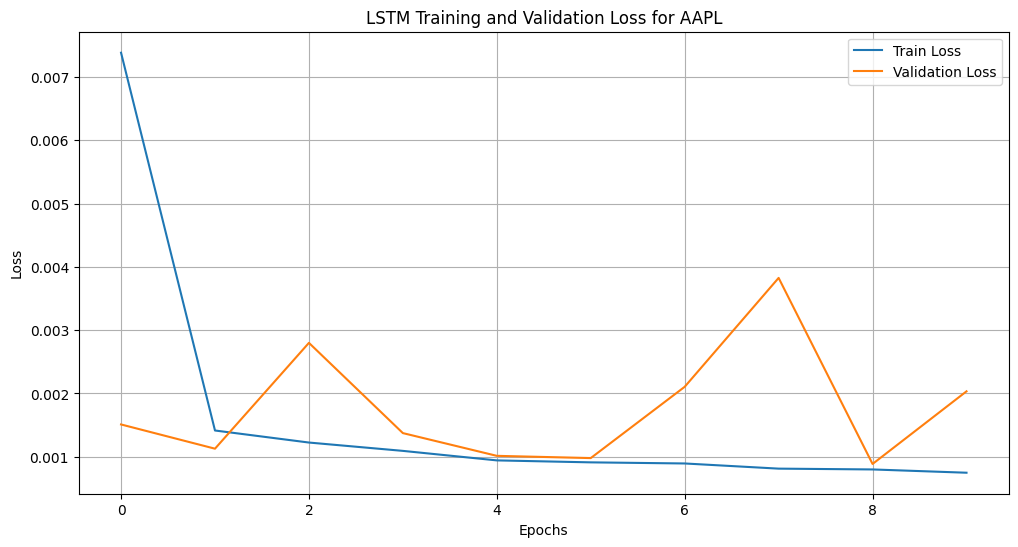

In [ ]:
# Build and train LSTM models for each company

# Function to create LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create and train models for each company
trained_models = {}
history_dict = {}

# Create models directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

for company in companies:
    print(f"\nTraining model for {company}...")
    X_train = processed_data[company]['X_train']
    y_train = processed_data[company]['y_train']

    input_shape = (X_train.shape[1], 1)
    model = create_lstm_model(input_shape)

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=10,  # Reduced for demonstration, increase for better results
        batch_size=32,
        validation_split=0.1,
        verbose=1
    )

    trained_models[company] = model
    history_dict[company] = history.history

    # Save the model
    model.save(f'models/{company}_model.h5')

    # Save the scaler
    with open(f'models/{company}_scaler.pkl', 'wb') as f:
        pickle.dump(processed_data[company]['scaler'], f)

# Plot training history for the first company (Apple) as an example
plt.figure(figsize=(12, 6))
plt.plot(history_dict['AAPL']['loss'], label='Train Loss')
plt.plot(history_dict['AAPL']['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss for AAPL')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Making predictions for AAPL...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
Making predictions for GOOG...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
Making predictions for MSFT...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
Making predictions for AMZN...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


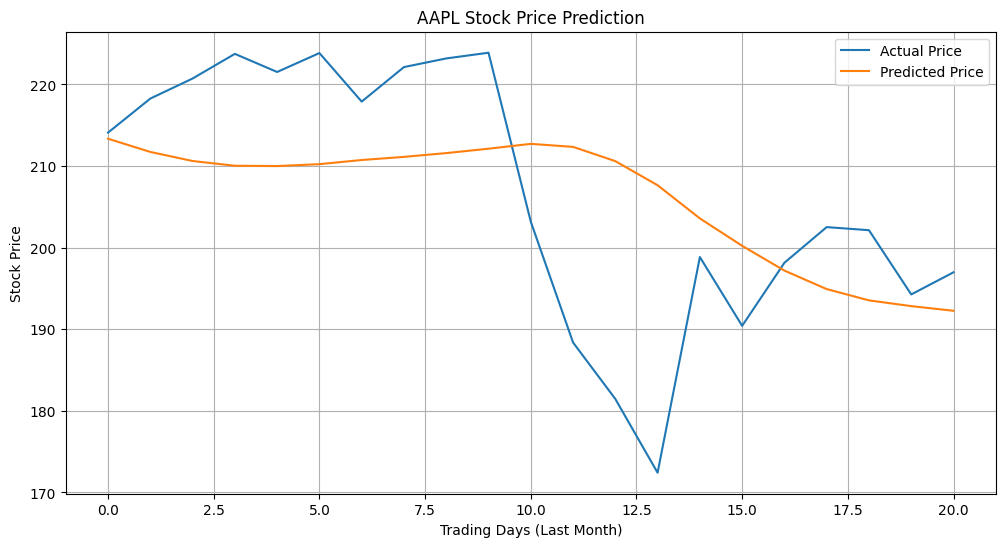

AAPL RMSE: 14.0214
AAPL - First 5 days comparison:
Day 1: Actual = 214.10, Predicted = 213.35, Diff = 0.75
Day 2: Actual = 218.27, Predicted = 211.73, Diff = 6.54
Day 3: Actual = 220.73, Predicted = 210.62, Diff = 10.11
Day 4: Actual = 223.75, Predicted = 210.04, Diff = 13.71
Day 5: Actual = 221.53, Predicted = 210.00, Diff = 11.53
GOOG RMSE: 6.3152
GOOG - First 5 days comparison:
Day 1: Actual = 165.05, Predicted = 164.74, Diff = 0.31
Day 2: Actual = 166.25, Predicted = 164.16, Diff = 2.09
Day 3: Actual = 169.93, Predicted = 163.71, Diff = 6.22
Day 4: Actual = 172.79, Predicted = 163.57, Diff = 9.22
Day 5: Actual = 167.14, Predicted = 163.78, Diff = 3.36
MSFT RMSE: 12.2184
MSFT - First 5 days comparison:
Day 1: Actual = 386.84, Predicted = 383.99, Diff = 2.85
Day 2: Actual = 391.26, Predicted = 383.69, Diff = 7.57
Day 3: Actual = 393.08, Predicted = 383.76, Diff = 9.32
Day 4: Actual = 395.16, Predicted = 384.16, Diff = 11.00
Day 5: Actual = 389.97, Predicted = 384.88, Diff = 5.09
AMZN

In [ ]:


# Function to make predictions
def make_predictions(company):
    # Load test data
    X_test = processed_data[company]['X_test']
    y_test = processed_data[company]['y_test']
    scaler = processed_data[company]['scaler']
    model = trained_models[company]

    # Make predictions
    predictions = model.predict(X_test)

    # Inverse transform to get actual price values
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    predictions_inv = scaler.inverse_transform(predictions)

    return y_test_inv, predictions_inv

# Get predictions for each company
predictions_dict = {}
for company in companies:
    print(f"Making predictions for {company}...")
    actual, predicted = make_predictions(company)
    predictions_dict[company] = {
        'actual': actual,
        'predicted': predicted
    }

# Plot actual vs predicted for Apple as an example
plt.figure(figsize=(12, 6))
plt.plot(predictions_dict['AAPL']['actual'], label='Actual Price')
plt.plot(predictions_dict['AAPL']['predicted'], label='Predicted Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Trading Days (Last Month)')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculate RMSE for each company
for company in companies:
    actual = predictions_dict[company]['actual']
    predicted = predictions_dict[company]['predicted']
    rmse = np.sqrt(np.mean(np.square(actual - predicted)))
    print(f"{company} RMSE: {rmse:.4f}")

    # Print some sample predictions
    print(f"{company} - First 5 days comparison:")
    for i in range(min(5, len(actual))):
        print(f"Day {i+1}: Actual = {actual[i][0]:.2f}, Predicted = {predicted[i][0]:.2f}, Diff = {abs(actual[i][0] - predicted[i][0]):.2f}")

In [ ]:
# Step 6: Create a Gradio interface

# Get actual dates from the stock data
dates = stock_data['AAPL'].index[-21:].strftime('%Y-%m-%d').tolist()

# Function to make prediction for a selected date and company
def predict_stock_price(selected_date, selected_company):
    # Find the index of the selected date in our test data
    try:
        date_index = dates.index(selected_date)
    except ValueError:
        return "Date not found in test data", "N/A", "N/A"

    # Get the actual and predicted values
    actual_value = predictions_dict[selected_company]['actual'][date_index][0]
    predicted_value = predictions_dict[selected_company]['predicted'][date_index][0]

    # Calculate the difference and percentage difference
    diff = predicted_value - actual_value
    pct_diff = (diff / actual_value) * 100

    result_text = f"For {selected_company} on {selected_date}:"
    actual_text = f"Actual Price: ${actual_value:.2f}"
    predicted_text = f"Predicted Price: ${predicted_value:.2f} (Diff: ${diff:.2f}, {pct_diff:.2f}%)"

    return result_text, actual_text, predicted_text

# Create the Gradio interface
with gr.Blocks(title="Stock Price Prediction with LSTM") as demo:
    gr.Markdown("# Stock Price Prediction with LSTM")
    gr.Markdown("Select a company and date to see the actual vs predicted stock price")

    with gr.Row():
        company_dropdown = gr.Dropdown(
            choices=companies,
            label="Select Company",
            # No default value
        )
        date_dropdown = gr.Dropdown(
            choices=dates,
            label="Select Date",
            # No default value
        )

    predict_button = gr.Button("Predict")

    result_text = gr.Textbox(label="Result")
    actual_price = gr.Textbox(label="Actual Price")
    predicted_price = gr.Textbox(label="Predicted Price")

    # Modify the update_plot function to return a blank plot if no company selected
    def update_plot(selected_company, trigger):
        if not selected_company or not trigger:
            # Return a blank figure if no company selected or button not clicked
            fig = plt.figure(figsize=(10, 6))
            plt.title("Please select a company and click Predict")
            plt.xlabel("Date")
            plt.ylabel("Stock Price ($)")
            plt.grid(True)
            plt.tight_layout()
            return fig

        fig = plt.figure(figsize=(10, 6))
        actual = predictions_dict[selected_company]['actual']
        predicted = predictions_dict[selected_company]['predicted']

        plt.plot(dates, actual, label='Actual Price', marker='o')
        plt.plot(dates, predicted, label='Predicted Price', marker='x')
        plt.title(f'{selected_company} Stock Price - Actual vs Predicted (Last Month)')
        plt.xlabel('Date')
        plt.ylabel('Stock Price ($)')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        return fig

    plot = gr.Plot(label="Price Comparison Plot")

    # Set up event handlers
    predict_button.click(
        fn=lambda date, company: [
            *predict_stock_price(date, company),  # This returns the 3 text outputs
            True  # This is a trigger value for the plot
        ],
        inputs=[date_dropdown, company_dropdown],
        outputs=[result_text, actual_price, predicted_price, gr.State(True)]
    ).then(
        fn=update_plot,
        inputs=[company_dropdown, gr.State(True)],
        outputs=[plot]
    )

    # Remove the company_dropdown.change event that was automatically updating the plot

In [ ]:
# Launch the interface
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6b96ffc54d125f13c4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# predict future stock prices for user-specified future dates

In [ ]:
def predict_future_price(company, future_days):
    model = trained_models[company]
    scaler = processed_data[company]['scaler']
    data = stock_data[company]['Close'].values.reshape(-1, 1)
    last_sequence = scaler.transform(data[-60:])

    predicted_prices = []

    current_seq = last_sequence.copy()
    for _ in range(future_days):
        input_seq = current_seq[-60:].reshape(1, 60, 1)
        next_price_scaled = model.predict(input_seq, verbose=0)[0][0]
        predicted_prices.append(next_price_scaled)

        next_price_scaled = np.array([[next_price_scaled]])
        current_seq = np.append(current_seq, next_price_scaled, axis=0)

    # Inverse transform the predicted prices
    predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1)).flatten()

    future_dates = pd.bdate_range(start=datetime.datetime.now(), periods=future_days + 1)[1:]
    return future_dates.strftime('%Y-%m-%d').tolist(), predicted_prices.tolist()


In [ ]:
with gr.Blocks() as future_app:
    gr.Markdown("## 📈 Predict Future Stock Price")

    with gr.Row():
        future_company_dropdown = gr.Dropdown(choices=companies, label="Select Company")
        future_days_input = gr.Number(label="Days into the Future", value=1, precision=0)

    future_predict_button = gr.Button("Predict Future Price")
    future_result_box = gr.Textbox(label="Predicted Future Prices")

    def predict_and_display_future(company, days):
        future_dates, prices = predict_future_price(company, int(days))
        result = "\n".join([f"{d}: ${p:.2f}" for d, p in zip(future_dates, prices)])
        return result

    future_predict_button.click(
        fn=predict_and_display_future,
        inputs=[future_company_dropdown, future_days_input],
        outputs=[future_result_box]
    )

In [ ]:
# 👇 Launch this interface
future_app.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bc44e8d4cab9d4bd3c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
